In [2]:

# Import Main Dependencies
import pandas as pd
import numpy as np
import json
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.stats as st

# Import credentials string for PostgreSQL database access
# from config import credentials

# Library and methods to connect and interact with database
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker

In [3]:
#Export data for cleaning
data = "Resources/Chicago_Energy_Benchmarking.csv"
chicago_energy_data = pd.read_csv(data)


chicago_energy_data.head()

,Data Year,ID,Property Name,Reporting Status,Address,ZIP Code,Chicago Energy Rating,Exempt From Chicago Energy Rating,Community Area,Primary Property Type,...,Site EUI (kBtu/sq ft),Source EUI (kBtu/sq ft),Weather Normalized Site EUI (kBtu/sq ft),Weather Normalized Source EUI (kBtu/sq ft),Total GHG Emissions (Metric Tons CO2e),GHG Intensity (kg CO2e/sq ft),Latitude,Longitude,Location,Row_ID
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,HYDE PARK,Library,...,240.8,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)",2020-252064
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,KENWOOD,Multifamily Housing,...,95.5,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)",2020-232458
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,NEAR WEST SIDE,Office,...,55.5,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)",2020-254616
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,NEAR NORTH SIDE,Office,...,61.4,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)",2020-103812
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,NEAR WEST SIDE,Multifamily Housing,...,29.4,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)",2020-254073


# View imported data

In [4]:
#Check dimensions of data 
print(f'Number of columns: {chicago_energy_data.columns.nunique()}')
print(f'Number of rows: {len(chicago_energy_data)}')

Number of columns: 30
Number of rows: 17728


In [5]:
#Extracting exempt buildings
exempt_chicago_energy = chicago_energy_data.loc[(chicago_energy_data["Reporting Status"]) == 'Exempt']
print(len(exempt_chicago_energy))

474


In [6]:
nonexempt_chicago_energy = chicago_energy_data.loc[(chicago_energy_data["Reporting Status"]) != 'Exempt']
print(len(nonexempt_chicago_energy))

17254


In [7]:
#Dropping unnecessary columns
nonexempt_chicago_energy = nonexempt_chicago_energy.drop(columns='Row_ID')

# Check for null values

In [8]:
#Each row has an Chicago Energy Rating
null_val_energy_rating = (nonexempt_chicago_energy["Chicago Energy Rating"]).notnull()
null_val_energy_rating.describe

<bound method NDFrame.describe of 0        True
1        True
2        True
3        True
4        True
         ... 
17723    True
17724    True
17725    True
17726    True
17727    True
Name: Chicago Energy Rating, Length: 17254, dtype: bool>

In [9]:
nonexempt_chicago_energy.replace(r'^\s+$', np.nan, regex=True)

,Data Year,ID,Property Name,Reporting Status,Address,ZIP Code,Chicago Energy Rating,Exempt From Chicago Energy Rating,Community Area,Primary Property Type,...,All Other Fuel Use (kBtu),Site EUI (kBtu/sq ft),Source EUI (kBtu/sq ft),Weather Normalized Site EUI (kBtu/sq ft),Weather Normalized Source EUI (kBtu/sq ft),Total GHG Emissions (Metric Tons CO2e),GHG Intensity (kg CO2e/sq ft),Latitude,Longitude,Location
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,HYDE PARK,Library,...,NaN,240.8,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)"
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,KENWOOD,Multifamily Housing,...,NaN,95.5,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)"
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,NEAR WEST SIDE,Office,...,NaN,55.5,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,NEAR NORTH SIDE,Office,...,NaN,61.4,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)"
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,NEAR WEST SIDE,Multifamily Housing,...,NaN,29.4,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17723,2019,260132,Q11970,Submitted,2401 W Grace St,60618,3.0,False,NORTH CENTER,NaN,...,NaN,72.5,165.6,71.7,NaN,NaN,NaN,41.950035,-87.688779,"(41.95003548, -87.68877942)"
17724,2019,260135,309-315 W. 23rd St. Condominium Assocation,Submitted,309 W 23RD ST,60616,4.0,False,ARMOUR SQUARE,Multifamily Housing,...,NaN,47.4,NaN,NaN,NaN,NaN,NaN,41.845504,-87.630557,"(41.84550365, -87.63055693)"
17725,2019,260149,Riverside Square and River's Edge - Chicago,Submitted,3145 S Ashland Ave,60608,2.0,False,MCKINLEY PARK,Supermarket/Grocery Store,...,NaN,254.7,566.2,253.4,NaN,2448.1,32.9,41.836579,-87.663845,"(41.8365795, -87.66384491)"
17726,2019,260150,Cummings Life Science Center,Submitted,920 E 58th St,60637,2.0,False,HYDE PARK,Laboratory,...,NaN,416.1,783.4,413.8,NaN,7815.5,45.3,41.789880,-87.602764,"(41.78987998, -87.60276375)"


In [10]:
#Check replacement of blank rows with sample column
print(nonexempt_chicago_energy["All Other Fuel Use (kBtu)"].unique())

[           nan 7.65072000e+04 7.86470010e+06 1.03500000e+05
 1.65600000e+04 1.40760000e+05 4.02546000e+04 7.00902000e+04
 8.85546000e+04 2.44002000e+05 8.41800000e+04 5.91575000e+04
 1.79262000e+04 4.00200000e+04 8.02970000e+04 2.85660000e+04
 1.10623000e+04 7.55680000e+06 6.78960000e+04 2.20110000e+04
 8.43777000e+04 1.24200000e+04 2.27050000e+05 1.73880000e+05
 1.93296590e+06 1.50420000e+04 6.66678000e+05 3.32580000e+04
 2.09817950e+07 1.31320000e+04 5.36682000e+04 1.10400000e+04
 7.69210000e+04 1.03590000e+07 3.31200000e+04 3.14640000e+04
 6.79140000e+06 1.03222000e+05 4.48247000e+04 7.61760000e+04
 1.08054000e+05 1.94041800e+06 5.51448000e+05 8.91299840e+06
 5.63040000e+04 1.86300000e+04 6.97189990e+06 1.88090000e+04
 8.43120000e+04 4.41600000e+04 1.50470000e+04 1.42140000e+05
 4.92110000e+04 4.27800000e+04 8.54910000e+04 3.45000000e+03
 9.78930000e+04 1.94041790e+06 3.65700000e+04 1.58700000e+04
 6.60470000e+04 9.68200000e+06 5.64553000e+04 5.32211000e+04
 1.46560000e+04 3.154900

In [11]:
# of buildings by community
buildings_by_comm = nonexempt_chicago_energy["Community Area"].value_counts()
buildings_by_comm

NEAR NORTH SIDE                     2697
LOOP                                1960
NEAR WEST SIDE                      1264
LAKE VIEW                            908
LINCOLN PARK                         706
                                    ... 
O'Hare                                 2
Lakeview                               1
West Lawn                              1
Pullman                                1
outside Chicago, in Bedford Park       1
Name: Community Area, Length: 130, dtype: int64

In [12]:
# electricity consumption by community
elec_consumption_by_comm = nonexempt_chicago_energy.groupby(["Community Area"]).sum()["Electricity Use (kBtu)"]
elec_consumption_by_comm


Community Area
ALBANY PARK                         2.087121e+08
ARCHER HEIGHTS                      2.880239e+08
ARMOUR SQUARE                       3.696204e+09
ASHBURN                             2.780577e+08
AUBURN GRESHAM                      1.727737e+08
                                        ...     
West Pullman                        3.832139e+07
West Ridge                          1.115617e+07
West Town                           1.863136e+08
Woodlawn                            1.319849e+07
outside Chicago, in Bedford Park    6.597050e+06
Name: Electricity Use (kBtu), Length: 130, dtype: float64

In [13]:
gas_consumption_by_comm = nonexempt_chicago_energy.groupby(["Community Area"]).sum()["Natural Gas Use (kBtu)"]
gas_consumption_by_comm

Community Area
ALBANY PARK                         3.932679e+08
ARCHER HEIGHTS                      1.787444e+08
ARMOUR SQUARE                       3.124932e+09
ASHBURN                             4.011668e+08
AUBURN GRESHAM                      3.904656e+08
                                        ...     
West Pullman                        6.363787e+07
West Ridge                          4.044531e+07
West Town                           2.155274e+08
Woodlawn                            1.822117e+07
outside Chicago, in Bedford Park    2.418400e+06
Name: Natural Gas Use (kBtu), Length: 130, dtype: float64

In [14]:
water_consumption_by_comm = nonexempt_chicago_energy.groupby(["Community Area"]).sum()["Water Use (kGal)"]
water_consumption_by_comm

Community Area
ALBANY PARK                          50775.0
ARCHER HEIGHTS                       20447.0
ARMOUR SQUARE                       163082.0
ASHBURN                              34077.0
AUBURN GRESHAM                       38496.0
                                      ...   
West Pullman                          9682.0
West Ridge                            9808.0
West Town                            26607.0
Woodlawn                              1245.0
outside Chicago, in Bedford Park         0.0
Name: Water Use (kGal), Length: 130, dtype: float64

In [15]:
avg_energy_star_by_comm = nonexempt_chicago_energy.groupby(["Community Area"]).mean()["ENERGY STAR Score"]
avg_energy_star_by_comm

Community Area
ALBANY PARK                         62.984848
ARCHER HEIGHTS                      54.935484
ARMOUR SQUARE                       63.862069
ASHBURN                             54.943662
AUBURN GRESHAM                      41.105263
                                      ...    
West Pullman                              NaN
West Ridge                          76.200000
West Town                           55.636364
Woodlawn                            60.800000
outside Chicago, in Bedford Park    70.000000
Name: ENERGY STAR Score, Length: 130, dtype: float64

In [16]:
#Change Column Names

In [17]:
nonexempt_chicago_energy=nonexempt_chicago_energy.rename(columns= {'Data Year':'data_year', 'ID': 'id', 'Property Name': 'property_name', 'Reporting Status':'reporting_status', 'Address': 'address', 'ZIP Code': 'zip_code',
                       'Chicago Energy Rating': 'chicago_energy_rating', 'Exempt From Chicago Energy Rating': 'exempt_from_chicago_energy_rating', 'Community Area': 'community_area', 'Primary Property Type': 'primary_property_type',
                              'Gross Floor Area - Buildings (sq ft)': 'gross_floor_area', 'Year Built': 'year_built', '# of Buildings': 'number_of_buildings', 'Water Use (kGal)': 'water_use', 'ENERGY STAR Score':'energy_star_score',
                              'Electricity Use (kBtu)': 'electricity_use', 'Natural Gas Use (kBtu)': 'natural_gas_use', 'District Steam Use (kBtu)': 'district_steam_use', 'District Chilled Water Use (kBtu)': 'district_chilled_water_use',
                              'All Other Fuel Use (kBtu)':'all_other_fuel_use', 'Site EUI (kBtu/sq ft)': 'site_eui', 'Source EUI (kBtu/sq ft)': 'source_eui', 'Weather Normalized Site EUI (kBtu/sq ft)': 'weather_normalized_site_eui', 'Weather Normalized Source EUI (kBtu/sq ft)': 'weather_normalized_source_eui', 'Total GHG Emissions (Metric Tons CO2e)': 'total_ghg_emissions', 'GHG Intensity (kg CO2e/sq ft)': 'ghg_intensity', 'Latitude': 'lat', 'Longitude': 'lon', 'Location': 'loc'})

In [18]:
nonexempt_chicago_energy.head()

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,all_other_fuel_use,site_eui,source_eui,weather_normalized_site_eui,weather_normalized_source_eui,total_ghg_emissions,ghg_intensity,lat,lon,loc
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,HYDE PARK,Library,...,NaN,240.8,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)"
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,KENWOOD,Multifamily Housing,...,NaN,95.5,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)"
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,NEAR WEST SIDE,Office,...,NaN,55.5,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,NEAR NORTH SIDE,Office,...,NaN,61.4,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)"
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,NEAR WEST SIDE,Multifamily Housing,...,NaN,29.4,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)"


In [19]:
# nonexempt_chicago_energy.to_csv("Resources/Clean_data.csv", index=False, header=True)

In [20]:
#additional data cleaning
#Dropping unnecessary columns
nonexempt_chicago_energy = nonexempt_chicago_energy.drop(columns='water_use')
nonexempt_chicago_energy = nonexempt_chicago_energy.drop(columns='district_chilled_water_use')
nonexempt_chicago_energy = nonexempt_chicago_energy.drop(columns='district_steam_use')
nonexempt_chicago_energy = nonexempt_chicago_energy.drop(columns='all_other_fuel_use')

nonexempt_chicago_energy.head()



,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,natural_gas_use,site_eui,source_eui,weather_normalized_site_eui,weather_normalized_source_eui,total_ghg_emissions,ghg_intensity,lat,lon,loc
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,HYDE PARK,Library,...,NaN,240.8,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)"
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,KENWOOD,Multifamily Housing,...,43537490.6,95.5,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)"
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,NEAR WEST SIDE,Office,...,2199940.1,55.5,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,NEAR NORTH SIDE,Office,...,1493523.2,61.4,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)"
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,NEAR WEST SIDE,Multifamily Housing,...,825006.6,29.4,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)"


In [21]:
nonexempt_chicago_energy.head()

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,natural_gas_use,site_eui,source_eui,weather_normalized_site_eui,weather_normalized_source_eui,total_ghg_emissions,ghg_intensity,lat,lon,loc
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,HYDE PARK,Library,...,NaN,240.8,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)"
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,KENWOOD,Multifamily Housing,...,43537490.6,95.5,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)"
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,NEAR WEST SIDE,Office,...,2199940.1,55.5,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,NEAR NORTH SIDE,Office,...,1493523.2,61.4,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)"
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,NEAR WEST SIDE,Multifamily Housing,...,825006.6,29.4,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)"


In [22]:
# Cleanup the numeric data & types
nonexempt_chicago_energy['zip_code'] = nonexempt_chicago_energy['zip_code'].replace(np.nan, 0)
# nonexempt_chicago_energy['zip_code'] = nonexempt_chicago_energy['zip_code'].astype(int)
nonexempt_chicago_energy['year_built'] = nonexempt_chicago_energy['year_built'].replace(np.nan, 0)
nonexempt_chicago_energy['number_of_buildings'] = nonexempt_chicago_energy['number_of_buildings'].replace(np.nan, 1)
nonexempt_chicago_energy['energy_star_score'] = nonexempt_chicago_energy['energy_star_score'].replace(np.nan, 0)
nonexempt_chicago_energy['natural_gas_use'] = nonexempt_chicago_energy['natural_gas_use'].replace(np.nan, 0.0)
nonexempt_chicago_energy['electricity_use'] = nonexempt_chicago_energy['electricity_use'].replace(np.nan, 0.0)
nonexempt_chicago_energy['site_eui'] = nonexempt_chicago_energy['site_eui'].replace(np.nan, 0.0)
nonexempt_chicago_energy['source_eui'] = nonexempt_chicago_energy['source_eui'].replace(np.nan, 0.0)
nonexempt_chicago_energy['weather_normalized_site_eui'] = nonexempt_chicago_energy['weather_normalized_site_eui'].replace(np.nan, 0.0)
nonexempt_chicago_energy['weather_normalized_source_eui'] = nonexempt_chicago_energy['weather_normalized_source_eui'].replace(np.nan, 0.0)
nonexempt_chicago_energy['total_ghg_emissions'] = nonexempt_chicago_energy['total_ghg_emissions'].replace(np.nan, 0.0)
nonexempt_chicago_energy['ghg_intensity'] = nonexempt_chicago_energy['ghg_intensity'].replace(np.nan, 0.0)



In [23]:
#progress check
nonexempt_chicago_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17254 entries, 0 to 17727
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   data_year                          17254 non-null  int64  
 1   id                                 17254 non-null  int64  
 2   property_name                      16199 non-null  object 
 3   reporting_status                   17254 non-null  object 
 4   address                            17254 non-null  object 
 5   zip_code                           17254 non-null  object 
 6   chicago_energy_rating              9735 non-null   float64
 7   exempt_from_chicago_energy_rating  9976 non-null   object 
 8   community_area                     17179 non-null  object 
 9   primary_property_type              15103 non-null  object 
 10  gross_floor_area                   15970 non-null  float64
 11  year_built                         17254 non-null  flo

In [24]:
#checking for blank cells
nonexempt_chicago_energy.count()

data_year                            17254
id                                   17254
property_name                        16199
reporting_status                     17254
address                              17254
zip_code                             17254
chicago_energy_rating                 9735
exempt_from_chicago_energy_rating     9976
community_area                       17179
primary_property_type                15103
gross_floor_area                     15970
year_built                           17254
number_of_buildings                  17254
energy_star_score                    17254
electricity_use                      17254
natural_gas_use                      17254
site_eui                             17254
source_eui                           17254
weather_normalized_site_eui          17254
weather_normalized_source_eui        17254
total_ghg_emissions                  17254
ghg_intensity                        17254
lat                                  17250
lon        

In [25]:
#fill blanks with appropriate data type
nonexempt_chicago_energy['property_name'] = nonexempt_chicago_energy['property_name'].replace(np.nan)
nonexempt_chicago_energy['community_area'] = nonexempt_chicago_energy['community_area'].replace(np.nan)
nonexempt_chicago_energy['primary_property_type'] = nonexempt_chicago_energy['primary_property_type'].replace(np.nan)
nonexempt_chicago_energy['gross_floor_area'] = nonexempt_chicago_energy['gross_floor_area'].replace(np.nan, 0.0)
nonexempt_chicago_energy['lat'] = nonexempt_chicago_energy['lat'].replace(np.nan, 0.0)
nonexempt_chicago_energy['lon'] = nonexempt_chicago_energy['lon'].replace(np.nan, 0.0)
nonexempt_chicago_energy['loc'] = nonexempt_chicago_energy['loc'].replace(np.nan)


In [26]:
#checking for blank cells
nonexempt_chicago_energy.count()

data_year                            17254
id                                   17254
property_name                        17254
reporting_status                     17254
address                              17254
zip_code                             17254
chicago_energy_rating                 9735
exempt_from_chicago_energy_rating     9976
community_area                       17254
primary_property_type                17254
gross_floor_area                     17254
year_built                           17254
number_of_buildings                  17254
energy_star_score                    17254
electricity_use                      17254
natural_gas_use                      17254
site_eui                             17254
source_eui                           17254
weather_normalized_site_eui          17254
weather_normalized_source_eui        17254
total_ghg_emissions                  17254
ghg_intensity                        17254
lat                                  17254
lon        

In [27]:
nonexempt_chicago_energy.head()

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,natural_gas_use,site_eui,source_eui,weather_normalized_site_eui,weather_normalized_source_eui,total_ghg_emissions,ghg_intensity,lat,lon,loc
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,HYDE PARK,Library,...,0.0,240.8,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)"
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,KENWOOD,Multifamily Housing,...,43537490.6,95.5,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)"
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,NEAR WEST SIDE,Office,...,2199940.1,55.5,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,NEAR NORTH SIDE,Office,...,1493523.2,61.4,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)"
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,NEAR WEST SIDE,Multifamily Housing,...,825006.6,29.4,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)"


In [28]:
clean_data_chi_energy = nonexempt_chicago_energy.dropna(how='any')

In [29]:
clean_data_chi_energy.count()

data_year                            9735
id                                   9735
property_name                        9735
reporting_status                     9735
address                              9735
zip_code                             9735
chicago_energy_rating                9735
exempt_from_chicago_energy_rating    9735
community_area                       9735
primary_property_type                9735
gross_floor_area                     9735
year_built                           9735
number_of_buildings                  9735
energy_star_score                    9735
electricity_use                      9735
natural_gas_use                      9735
site_eui                             9735
source_eui                           9735
weather_normalized_site_eui          9735
weather_normalized_source_eui        9735
total_ghg_emissions                  9735
ghg_intensity                        9735
lat                                  9735
lon                               

In [56]:
unique_communities = clean_data_chi_energy["zip_code"].unique()
unique_communities

array(['60637', '60615', '60607', '60654', '60621', '60614', '60616',
       '60605', '60626', '60632', '60625', '60634', '60611', '60622',
       '60661', '60640', '60639', '60657', '60601', '60610', '60612',
       '60629', '60643', '60613', '60603', '60606', '60624', '60623',
       '60617', '60630', '60660', '60618', '60652', '60649', '60653',
       '60633', '60645', '60620', '60644', 0, '60602', '60608', '60647',
       '60619', '60638', '60641', '60631', '60636', '60609', '60642',
       '60651', '60646', '60656', '60604', '60628', '60827', '60626-1864',
       '60707', '60659', '60666', '60655', '60048', '60602-3902',
       '60631-3485', '60601-2404', '60639-449', '60637-2890',
       '60616-5183', '606114594', '60637-3896', '60607-3802',
       '60642-4205', '60627', '60680', '60616-0000', '60640-4044',
       '60628-1598', '60615-4557', '60607-3101', '60691', '60604-3589',
       '60614-5664', '60611-2822', '60661-3061', '60615-4214',
       '60603-3233', '60640-7528', '6060

In [30]:
#load dataframe to csv
clean_data_chi_energy.to_csv("Resources/Clean_data.csv", index=False, header=True)

In [51]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
elec_consumption_zip= clean_data_chi_energy.groupby("zip_code").mean()['electricity_use']
gas_consumption_zip= clean_data_chi_energy.groupby("zip_code").median()['natural_gas_use']
total_ghg_emissions_zip= clean_data_chi_energy.groupby("zip_code").median()['total_ghg_emissions']
energy_star_score_zip= clean_data_chi_energy.groupby("zip_code").median()['energy_star_score']
chicago_energy_score_zip= clean_data_chi_energy.groupby("zip_code").median()['chicago_energy_rating']

consumption_summary_table_zip= pd.DataFrame({"Avg Electricity Use (kBtu)": elec_consumption_zip,
                            "Avg Natural Gas Use (kBtu)": gas_consumption_zip,
                            "Avg Total Emissions (Metric Tons CO2e)": total_ghg_emissions_zip,
                            "Avg Energy Star Score 0-100": energy_star_score_zip,
                            "Avg Chicago Energy Rating 0-4": chicago_energy_score_zip})

consumption_summary_table_zip

,Avg Electricity Use (kBtu),Avg Natural Gas Use (kBtu),Avg Total Emissions (Metric Tons CO2e),Avg Energy Star Score 0-100,Avg Chicago Energy Rating 0-4
zip_code,,,,,
0,6.250181e+05,0.00,0.00,0.0,0.00
2210,2.153799e+07,37028347.55,3580.75,21.5,1.25
60048,0.000000e+00,0.00,0.00,0.0,0.00
60091,5.417301e+05,3490795.20,275.50,93.0,4.00
60302,9.207077e+05,6123988.60,0.00,46.0,2.00
...,...,...,...,...,...
60666,1.288523e+07,6887129.10,2593.50,30.0,1.50
60680,2.957197e+06,18254102.50,1461.55,5.5,1.00
60691,4.252150e+06,105678.00,713.00,75.0,3.50


In [ ]:
elec_consumption= clean_data_chi_energy.groupby("community_area").mean()['electricity_use']
gas_consumption= clean_data_chi_energy.groupby("community_area").median()['natural_gas_use']
total_ghg_emissions= clean_data_chi_energy.groupby("community_area").median()['total_ghg_emissions']
energy_star_score= clean_data_chi_energy.groupby("community_area").median()['energy_star_score']
chicago_energy_score= clean_data_chi_energy.groupby("community_area").median()['chicago_energy_rating']

consumption_summary_table= pd.DataFrame({"Avg Electricity Use (kBtu)": elec_consumption,
                            "Avg Natural Gas Use (kBtu)": gas_consumption,
                            "Avg Total Emissions (Metric Tons CO2e)": total_ghg_emissions,
                            "Avg Energy Star Score 0-100": energy_star_score,
                            "Avg Chicago Energy Rating 0-4": chicago_energy_score})

consumption_summary_table

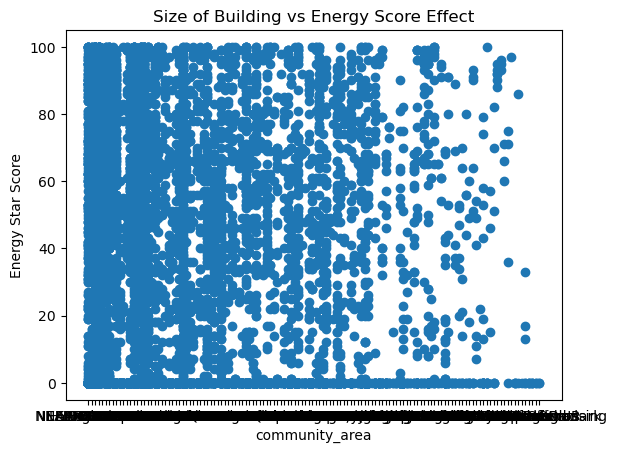

In [57]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


plt.scatter(clean_data_chi_energy[""],clean_data_chi_energy["energy_star_score"])

plt.xlabel("community_area")
plt.ylabel("Energy Star Score")
plt.title("Size of Building vs Energy Score Effect")
plt.show()

The correlation between energy_star_score and the gross_floor_area is 0.17


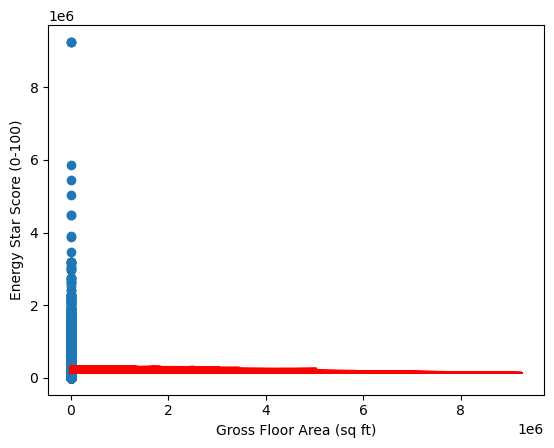

In [53]:
corr=round(st.pearsonr(clean_data_chi_energy["energy_star_score"],clean_data_chi_energy["gross_floor_area"])[0],2)
print(f"The correlation between energy_star_score and the gross_floor_area is {corr}")

model= st.linregress(clean_data_chi_energy["energy_star_score"],clean_data_chi_energy["gross_floor_area"])

y_values = clean_data_chi_energy["energy_star_score"]*model[0]+model[1]   
plt.scatter(clean_data_chi_energy["energy_star_score"],clean_data_chi_energy["gross_floor_area"])
plt.plot(clean_data_chi_energy["gross_floor_area"], y_values, color="red") 
plt.xlabel("Gross Floor Area (sq ft)")
plt.ylabel("Energy Star Score (0-100)")
      
plt.show()

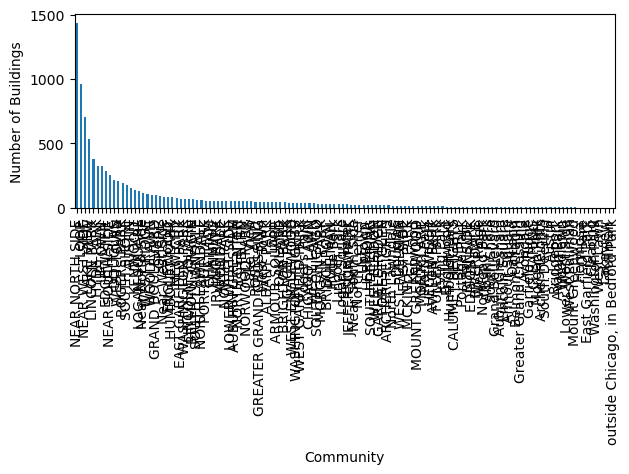

In [65]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

drug_regimen_count = clean_data_chi_energy["community_area"].value_counts()

drug_regimen_chart = drug_regimen_count.plot(kind="bar")
drug_regimen_chart.set_xlabel("Community")
drug_regimen_chart.set_ylabel("Number of Buildings")

plt.show
plt.tight_layout()

g = clean_data_chi_energy.groupby('community_area', as_index=False)['community_area'].count().sort_values(by='community_area', ascending=False).head(10)

